In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.modules.conv as conv
import torch.utils.data as utils
import torch.nn.functional as F

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [2]:
class AddCoords(nn.Module):
    def __init__(self, rank, with_r=False):
        super(AddCoords, self).__init__()
        self.rank = rank
        self.with_r = with_r

    def forward(self, input_tensor):
        r"""
        input_tensor: (N, C_in,H,W)
        :param input_tensor:
        :return:
        """
        if self.rank == 1:
            raise NotImplementedError
            batch_size_shape, channel_in_shape, dim_x = input_tensor.shape
            xx_range = torch.arange(dim_x, dtype=torch.int32).unsqueeze(0)
            xx_channel = xx_range.unsqueeze(0)

            xx_channel = xx_channel.float() / (dim_x - 1)
            xx_channel = xx_channel * 2 - 1
            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1)

            if torch.cuda.is_available:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
            out = torch.cat([input_tensor, xx_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)
        elif self.rank == 2:
            batch_size_shape, channel_in_shape, dim_y, dim_x = input_tensor.shape
            xx_ones = torch.ones([1, dim_x], dtype=torch.int32)
            yy_ones = torch.ones([1, dim_y], dtype=torch.int32)

            xx_range = torch.arange(dim_y, dtype=torch.int32).unsqueeze(0)
            yy_range = torch.arange(dim_x, dtype=torch.int32).unsqueeze(0)
            xx_range = xx_range.unsqueeze(-1)
            yy_range = yy_range.unsqueeze(-1)
            
            xx_channel = torch.matmul(xx_range, xx_ones)
            yy_channel = torch.matmul(yy_range, yy_ones)
            xx_channel = xx_channel.unsqueeze(0)
            yy_channel = yy_channel.unsqueeze(0)
            
            # transpose y
            yy_channel = yy_channel.permute(0, 1, 3, 2)
            
            xx_channel = xx_channel.float() / (dim_y - 1)
            yy_channel = yy_channel.float() / (dim_x - 1)

            xx_channel = xx_channel * 2 - 1
            yy_channel = yy_channel * 2 - 1

            xx_channel = xx_channel.repeat(batch_size_shape, 1, 1, 1)
            yy_channel = yy_channel.repeat(batch_size_shape, 1, 1, 1)

            if torch.cuda.is_available:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
                yy_channel = yy_channel.cuda()
            out = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)
        elif self.rank == 3:
            batch_size_shape, channel_in_shape, dim_z, dim_y, dim_x = input_tensor.shape
            xx_ones = torch.ones([1, dim_x], dtype=torch.int32)
            yy_ones = torch.ones([1, dim_y], dtype=torch.int32)
            zz_ones = torch.ones([1, dim_z], dtype=torch.int32)

            xy_range = torch.arange(dim_y, dtype=torch.int32).unsqueeze(0)
            xy_range = xy_range.unsqueeze(-1)

            yz_range = torch.arange(dim_z, dtype=torch.int32).unsqueeze(0)
            yz_range = yz_range.unsqueeze(-1)

            zx_range = torch.arange(dim_x, dtype=torch.int32).unsqueeze(0)
            zx_range = zx_range.unsqueeze(-1)

            xy_channel = torch.matmul(xy_range, xx_ones)
            xy_channel = xy_channel.unsqueeze(0)
            xx_channel = torch.stack([xy_channel + i for i in range(dim_z)], dim=2)

            yz_channel = torch.matmul(yz_range, yy_ones)
            yz_channel = yz_channel.unsqueeze(0)
            yy_channel = torch.stack([yz_channel + i for i in range(dim_x)], dim=4)

            zx_channel = torch.matmul(zx_range, zz_ones)
            zx_channel = zx_channel.unsqueeze(0)
            zx_channel = zx_channel.permute(0,1,3,2)
            zz_channel = torch.stack([zx_channel + i for i in range(dim_y)], dim=3) 

            if torch.cuda.is_available:
                input_tensor = input_tensor.cuda()
                xx_channel = xx_channel.cuda()
                yy_channel = yy_channel.cuda()
                zz_channel = zz_channel.cuda()
            out = torch.cat([input_tensor, xx_channel, yy_channel, zz_channel], dim=1)

            if self.with_r:
                rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) +\
                                torch.pow(yy_channel - 0.5, 2) +\
                                torch.pow(zz_channel - 0.5, 2))
                out = torch.cat([out, rr], dim=1)
        else:
            raise NotImplementedError

        return out


class CoordConv2d(conv.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, with_r=False):
        super(CoordConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                          stride, padding, dilation, groups, bias)
        self.rank = 2
        self.addcoords = AddCoords(self.rank, with_r)
        self.conv = nn.Conv2d(in_channels+self.rank+int(with_r), out_channels,
                              kernel_size, stride, padding, dilation, groups, bias)

    def forward(self, input_tensor):
        r"""
        输入的尺度是(N, C_in,H,W)，输出尺度（N,C_out,H_out,W_out）
        :param input_tensor:
        :return:
        """
        out = self.addcoords(input_tensor)
        out = self.conv(out)

        return out

## Generate Data

In [3]:
datatype = 'uniform'
assert datatype in ['uniform', 'quadrant']

if not os.path.exists('data-uniform/'):
    os.makedirs('data-uniform/')

if not os.path.exists('data-quadrant/'):
    os.makedirs('data-quadrant/')

np.random.seed(0)
torch.manual_seed(0)

In [4]:
onehots = np.pad(np.eye(3136, dtype='float32').reshape((3136, 56, 56, 1)),
                     ((0, 0), (4, 4), (4, 4), (0, 0)), mode="constant")
onehots = onehots.transpose(0, 3, 1, 2)

onehots_tensor = torch.from_numpy(onehots)

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(9,9), padding=4, stride=1)
w = torch.ones(1,1,9, 9)
conv_layer.weight.data = w

images_tensor = conv_layer(onehots_tensor)
images = images_tensor.detach().numpy()

if datatype == 'uniform':
    # Create the uniform datasets
    indices = np.arange(0, len(onehots), dtype='int32')
    train, test = train_test_split(indices, test_size=0.2, random_state=0)

    train_onehot = onehots[train]
    train_images = images[train]

    test_onehot = onehots[test]
    test_images = images[test]

    np.save('data-uniform/train_onehot.npy', train_onehot)
    np.save('data-uniform/train_images.npy', train_images)
    np.save('data-uniform/test_onehot.npy', test_onehot)
    np.save('data-uniform/test_images.npy', test_images)
else:
    pos_quadrant = np.where(onehots == 1.0)
#     print(onehots.shape)
    X = pos_quadrant[2]
    Y = pos_quadrant[3]
    
    train_set = []
    test_set = []

    train_ids = []
    test_ids = []

    for i, (x, y) in enumerate(zip(X, Y)):
        if x > 32 and y > 32:  # 4th quadrant
            test_ids.append(i)
            test_set.append([x, y])
        else:
            train_ids.append(i)
            train_set.append([x, y])

    train_set = np.array(train_set)
    test_set = np.array(test_set)
    
    train_set = train_set[:, None, None, :]
    test_set = test_set[:, None, None, :]

    print(train_set.shape)
    print(test_set.shape)

    train_onehot = onehots[train_ids]
    test_onehot = onehots[test_ids]

    train_images = images[train_ids]
    test_images = images[test_ids]

    print(train_onehot.shape, test_onehot.shape)
    print(train_images.shape, test_images.shape)

    np.save('data-quadrant/train_set.npy', train_set)
    np.save('data-quadrant/test_set.npy', test_set)
    np.save('data-quadrant/train_onehot.npy', train_onehot)
    np.save('data-quadrant/train_images.npy', train_images)
    np.save('data-quadrant/test_onehot.npy', test_onehot)
    np.save('data-quadrant/test_images.npy', test_images)

## Load data numpy

Train set :  (2508, 2, 64, 64) 0.93650794 0.06349207
Test set :  (628, 2, 64, 64) 0.93650794 0.06349207


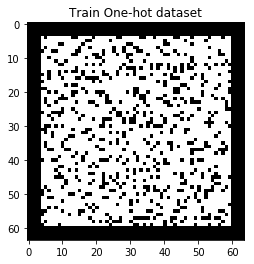

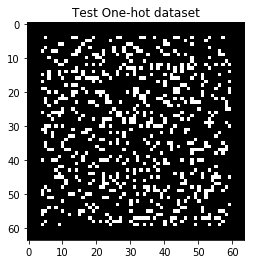

In [5]:
if datatype == 'uniform':
    # Load the one hot datasets
    train_onehot = np.load('data-uniform/train_onehot.npy').astype('float32')
    test_onehot = np.load('data-uniform/test_onehot.npy').astype('float32')

    # (N, C, H, W) <=== 数据格式
    # make the train and test datasets
    # train
    pos_train = np.where(train_onehot == 1.0)
    X_train = pos_train[2]
    Y_train = pos_train[3]
    train_set = np.zeros((len(X_train), 2, 1, 1), dtype='float32')
    for i, (x, y) in enumerate(zip(X_train, Y_train)):
        train_set[i, 0, 0, 0] = x
        train_set[i, 1, 0, 0] = y

    # test
    pos_test = np.where(test_onehot == 1.0)
    X_test = pos_test[2]
    Y_test = pos_test[3]
    test_set = np.zeros((len(X_test), 2, 1, 1), dtype='float32')
    for i, (x, y) in enumerate(zip(X_test, Y_test)):
        test_set[i, 0, 0, 0] = x
        test_set[i, 1, 0, 0] = y

    train_set = np.tile(train_set, [1, 1, 64, 64])
    test_set = np.tile(test_set, [1, 1, 64, 64])

    # Normalize the datasets
    train_set /= (64. - 1.)  # 64x64 grid, 0-based index
    test_set /= (64. - 1.)  # 64x64 grid, 0-based index

    print('Train set : ', train_set.shape, train_set.max(), train_set.min())
    print('Test set : ', test_set.shape, test_set.max(), test_set.min())

    # Visualize the datasets

    plt.imshow(np.sum(train_onehot, axis=0)[0, :, :], cmap='gray')
    plt.title('Train One-hot dataset')
    plt.show()
    plt.imshow(np.sum(test_onehot, axis=0)[0, :, :], cmap='gray')
    plt.title('Test One-hot dataset')
    plt.show()

else:
    # Load the one hot datasets and the train / test set
    train_set = np.load('data-quadrant/train_set.npy').astype('float32')
    test_set = np.load('data-quadrant/test_set.npy').astype('float32')

    train_onehot = np.load('data-quadrant/train_onehot.npy').astype('float32')
    test_onehot = np.load('data-quadrant/test_onehot.npy').astype('float32')

    train_set = np.tile(train_set, [1, 1, 64, 64])
    test_set = np.tile(test_set, [1, 1, 64, 64])

    # Normalize datasets
    train_set /= train_set.max()
    test_set /= test_set.max()

    print('Train set : ', train_set.shape, train_set.max(), train_set.min())
    print('Test set : ', test_set.shape, test_set.max(), test_set.min())

    # Visualize the datasets

    plt.imshow(np.sum(train_onehot, axis=0)[0, :, :], cmap='gray')
    plt.title('Train One-hot dataset')
    plt.show()
    plt.imshow(np.sum(test_onehot, axis=0)[0, :, :], cmap='gray')
    plt.title('Test One-hot dataset')
    plt.show()

In [6]:
# flatten the datasets
train_onehot = train_onehot.reshape((-1, 64 * 64)).astype('int64')
test_onehot = test_onehot.reshape((-1, 64 * 64)).astype('int64')

In [7]:
# model definition

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.coordconv = CoordConv2d(2, 32, 1, with_r=True)
        self.conv1 = nn.Conv2d(32, 64, 1)
        self.conv2 = nn.Conv2d(64, 64, 1)
        self.conv3 = nn.Conv2d(64,  1, 1)
        self.conv4 = nn.Conv2d( 1,  1, 1)

    def forward(self, x):
        x = self.coordconv(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(-1, 64*64)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

summary(net, input_size=(2, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AddCoords-1            [-1, 5, 64, 64]               0
            Conv2d-2           [-1, 32, 64, 64]             192
       CoordConv2d-3           [-1, 32, 64, 64]              96
            Conv2d-4           [-1, 64, 64, 64]           2,112
            Conv2d-5           [-1, 64, 64, 64]           4,160
            Conv2d-6            [-1, 1, 64, 64]              65
            Conv2d-7            [-1, 1, 64, 64]               2
Total params: 6,627
Trainable params: 6,627
Non-trainable params: 0
----------------------------------------------------------------


## Make Datasets

In [8]:
train_tensor_x = torch.stack([torch.Tensor(i) for i in train_set])
train_tensor_y = torch.stack([torch.LongTensor(i) for i in train_onehot])

train_dataset = utils.TensorDataset(train_tensor_x,train_tensor_y)
train_dataloader = utils.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_tensor_x = torch.stack([torch.Tensor(i) for i in test_set])
test_tensor_y = torch.stack([torch.LongTensor(i) for i in test_onehot])

test_dataset = utils.TensorDataset(test_tensor_x,test_tensor_y)
test_dataloader = utils.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
def cross_entropy_one_hot(input, target):
    _, labels = target.max(dim=1)
    return nn.CrossEntropyLoss()(input, labels)
criterion = cross_entropy_one_hot
epochs = 10

In [10]:
def train(epoch, net, train_dataloader, optimizer, criterion, device):
    net.train()
    iters = 0
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        iters += len(data)
        print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, iters, len(train_dataloader.dataset),
                100. * (batch_idx + 1) / len(train_dataloader), loss.data.item()), end='\r', flush=True)
    print("")

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch, net, train_dataloader, optimizer, criterion, device)

Train Epoch: 1 [2508/2508 (100%)] Loss: 7.505956
Train Epoch: 2 [2508/2508 (100%)] Loss: 4.008380
Train Epoch: 3 [2508/2508 (100%)] Loss: 2.033982
Train Epoch: 4 [2508/2508 (100%)] Loss: 0.994723
Train Epoch: 5 [2508/2508 (100%)] Loss: 0.472303
Train Epoch: 6 [2508/2508 (100%)] Loss: 0.254768
Train Epoch: 7 [2508/2508 (100%)] Loss: 0.135046
Train Epoch: 8 [2508/2508 (100%)] Loss: 0.087108
Train Epoch: 9 [2508/2508 (100%)] Loss: 0.060861
Train Epoch: 10 [2508/2508 (100%)] Loss: 0.046419


In [12]:
def test(net, test_loader, optimizer, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        output = net(data)
        test_loss += criterion(output, target).item()
        _, pred = output.max(1, keepdim=True)
        _, label = target.max(dim=1)
        correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
test(net, test_dataloader, optimizer, criterion, device)


Test set: Average loss: 0.0461, Accuracy: 628/628 (100%)

